In [1]:
from vedo import *
import os
from ipyvtklink.viewer import ViewInteractiveWidget
import pykitti
import numpy as np
# import tensorflow as tf
# from tensorflow.math import sin, cos, tan
import tensorflow_probability as tfp
import pickle
import matplotlib.pyplot as plt

# #limit GPU memory ------------------------------------------------
# gpus = tf.config.experimental.list_physical_devices('GPU')
# print(gpus)
# if gpus:
#   try:
#     memlim = 4*1024
#     tf.config.experimental.set_virtual_device_configuration(gpus[0], [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=memlim)])
#   except RuntimeError as e:
#     print(e)
# #-----------------------------------------------------------------


%load_ext autoreload
%autoreload 2
%autosave 180
%matplotlib notebook


Autosaving every 180 seconds


## KITTI-CARLA

In [2]:
def R2Euler(mat):
    if len( np.shape(mat) ) == 2:
        mat = mat[None, :, :]
    R_sum = np.sqrt(( mat[:,0,0]**2 + mat[:,0,1]**2 + mat[:,1,2]**2 + mat[:,2,2]**2 ) / 2)
    phi = np.arctan2(-mat[:,1,2],mat[:,2,2])
    theta = np.arctan2(mat[:,0,2], R_sum)
    psi = np.arctan2(-mat[:,0,1], mat[:,0,0])
    angs = np.array([phi, theta, psi])
    return angs

(500000, 13)
[-7.46527640e+01 -1.27708032e+02  1.67369843e-04]


<IPython.core.display.Javascript object>


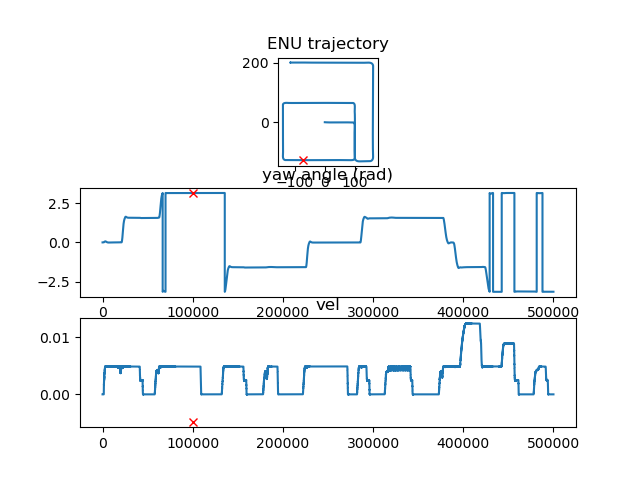

(3, 499999)


In [5]:
#get ground truth transformation
fpl = np.loadtxt("/home/derm/KITTICARLA/dataset/Town01/generated/full_poses_lidar.txt") #full poses lidar
print(np.shape(fpl))

#plot pose at arbitrary point in drive NEED TO MULTIPLY THIS BY 100??!
idx = 1000 #1050 for town1, 50 for town7

#create rotation vector
R = np.array([[fpl[:,0], fpl[:,1], fpl[:,2]],
              [fpl[:,4], fpl[:,5], fpl[:,6]],
              [fpl[:,8], fpl[:,9], fpl[:,10]]]).T
# R = np.transpose(R, (0,2,1))
# print(np.shape(R))
# print(R[-3])

angs = R2Euler(R) #convert to euler angles (for use with ICET)
# print(angs.T)

T = np.array([fpl[:,3], fpl[:,7], fpl[:,11]]).T #get translation vector
print(T[idx*100])

#plot results
fig, ax = plt.subplots(3,1)
ax[0].plot(T[:,0], T[:,1])
ax[0].plot(T[idx*100,0], T[idx*100,1], 'rx')
ax[0].set_aspect("equal")
ax[0].set_title("ENU trajectory")

ax[1].set_title("yaw angle (rad)")
ax[1].plot(angs[2,:])
ax[1].plot(idx*100, angs[2,idx*100], 'rx')

#TODO: get change in angles between subsequent transformations, fixangs greater than 2pi
vel = np.diff(T.T)
print(np.shape(vel))
ax[2].set_title("vel")
ax[2].plot(np.sqrt(vel[0,:]**2 + vel[1,:]**2))
ax[2].plot(idx*100, vel[0,idx*100], 'rx')

#sanity check for consistant timesteps...
# dt = np.diff(fpl[:,12])
# bad = dt[abs(dt[:] - 0.001) > 0.00001]
# print(bad)

In [6]:
import trimesh

skip = 5
noise_scale = 0.01
plt1 = Plotter(N = 1, axes = 7, bg = (1, 1, 1), interactive = True)
disp = []

s1_fn = '/home/derm/KITTICARLA/dataset/Town01/generated/frames/frame_%04d.ply' %(idx)
s2_fn = '/home/derm/KITTICARLA/dataset/Town01/generated/frames/frame_%04d.ply' %(idx+skip)

dat1 = trimesh.load(s1_fn)
dat2 = trimesh.load(s2_fn)

c1 = dat1.vertices
# c1 += true_traj[(idx)*100]
c1 = c1.dot(R[(idx)*100])
# mesh = Mesh(dat1).c("gray").alpha(1) #draw ignored points on ground plane
# disp.append(mesh)

c2 = dat2.vertices
# c2 += true_traj[(idx+skip)*100]
c2 = c2.dot(R[(idx+skip)*100])
# c2 = c2 + (vel[:,(idx+skip)*100] + vel[:,(idx)*100])*50*(skip) #transform c2 to overlay with c1 #was this
# correction = np.sum(vel[:,((idx-1)*100):((idx-1+skip)*100)], axis = 1) #test1
# c2 = c2 + correction
# print(correction)

# c1 = c1[c1[:,2] > -1.5]
# c2 = c2[c2[:,2] > -1.5] #ground + sidewalk

#display overal trajectory via "poses_lidar.ply" ~~~~~~~~~~~~~~~~~~~~~~~~~~
fn = "/home/derm/KITTICARLA/dataset/Town01/generated/poses_lidar.ply"
datposes = trimesh.load(fn)
true_traj = datposes.vertices
# print(true_traj)
disp.append(Points(true_traj - [0, 0, 1.65], alpha = 0.3))

#true location (for viz)
c1 += true_traj[(idx)*100]
c2 += true_traj[(idx+skip)*100]
#center at 0 (for training data)
# c2 += true_traj[(idx+skip)*100] - true_traj[(idx)*100]
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
c1 += noise_scale*np.random.randn(np.shape(c1)[0],3)
c2 += noise_scale*np.random.randn(np.shape(c2)[0],3)

disp.append(Points(c1, c = 'red', r = 2, alpha = 1.0))
disp.append(Points(c2, c = 'blue', r = 2, alpha = 1.0))

disp.append(Points(np.array([[0.,0.,0.]]), c = 'purple', r =10))
plt1.show(disp, "surface sampling test")
ViewInteractiveWidget(plt1.window)

ViewInteractiveWidget(height=1043, layout=Layout(height='auto', width='100%'), width=1920)

In [ ]:
from transforms3d.euler import mat2euler, euler2mat
print(euler2mat(0,0,0.1))

## TIERS

In [ ]:
filename = 'C:/TIERS/forest01_optitrack.csv'
# filename = 'C:/TIERS/forest02_optitrack.csv'

data = np.loadtxt(filename, delimiter=",", usecols = range(11))
# [timestamp, pose.position.x,  pose.position.y,  pose.position.z, 
#   roll, pitch, yaw, pose.orientation.x, pose.orientation.y, pose.orientation.z, 
#   pose.orientation.w ]

# print(np.diff(data, axis = 0))
gt = data[:,1:4]
# print(gt)

fig, ax = plt.subplots()
ax.plot(gt[:,0], gt[:,1])


In [ ]:
#CODD
import h5py

# filename = 'C:/CODD/data/m1v7p7s769.hdf5'
# filename = 'C:/CODD/data/m5v10p6s31.hdf5' #turn on country road
# filename = 'C:/CODD/data/m2v7p3s333.hdf5' #complex geometries
filename = 'C:/CODD/data/m10v11p6s30.hdf5' #wide road, traffic and palm trees

vidx = 0

with h5py.File(filename, 'r') as hf:
#     pcls = hf['point_cloud'][:]
    #[frames, vehicles, points_per_cloud, 4]
    pcls = hf['point_cloud'][:, vidx ,: , :3]
    #[frames, points_per_cloud, rgb]
    
#     pose = hf['lidar_pose'][:]
    #[frames, vehicles, (x,y,z, rotx, roty, rotz)]
    pose = hf['lidar_pose'][:, vidx, :]
    
    vbb = hf['vehicle_boundingbox'][:, vidx, :]
    
print(np.shape(pcls))
print(np.shape(pose))
print(np.shape(vbb))

#these are the same
# print(pose[1,:])
# print(vbb[1,:])


In [ ]:

plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams["font.size"] = 12
fig, ax = plt.subplots(2,1)

component = 0 #fwd translation 
# component = 5 #yaw

vel = np.diff(pose, axis = 0)

vf = np.sqrt(vel[:,0]**2 + vel[:,1]**2 ) # if plotting forward translation
# vf = vel[:,4]#*np.pi/180 #for yaw

# #test
# component = 3
# vf = -vel[:,5] 
# vf = vf*0
# vf = vel[:,2]

ax[0].plot(vf, label = 'Ground Truth Translation')
# ax.plot(np.diff(pose, axis = 0)[:,4])  
# ax.scatter(pose[:,0], pose[:,1])  
print(np.shape(vf))

estimates = np.loadtxt('ICET_estimates_CODD_v6.txt') #123
pred_stds = np.loadtxt('ICET_pred_stds_CODD_v6.txt')
estimates[:,3:] = estimates[:,3:]*180/np.pi 
pred_stds[:,3:] = pred_stds[:,3:]*180/np.pi 

# estimates = np.loadtxt('ICET_estimates_CODD_v4.txt') #20
# pred_stds = np.loadtxt('ICET_pred_stds_CODD_v4.txt')
# vf = vf[:23]

# print(estimates[:,0])
ax[0].plot(estimates[:,component], label = "ICET Estimated Translation")
# ax[0].plot(estimates[:,0] + pred_stds[:,0], color = [0,0,0], alpha = 0.1)
# ax[0].plot(estimates[:,0] - pred_stds[:,0], color = [0,0,0], alpha = 0.1)
ax[0].fill_between(np.linspace(0,123,124), 
                   vf - 2*pred_stds[:,component], vf + 2*pred_stds[:,component], 
                   color = [0,0,0], alpha = 0.2, label = 'Predicted 2σ Error Bound')
ax[0].set_xlabel("frame")
ax[0].set_ylabel("forward translation per frame (m)")
# ax[0].set_ylabel("change in yaw per frame (deg)")
ax[0].legend(loc = 'lower right')
# ax[0].set_tile("Simple Outlier Rejection")

ferr = vf - estimates[:,0]
# ax[1].plot(abs(ferr))
# ax[1].plot(pred_stds[:,0])
ax[1].scatter(abs(ferr), pred_stds[:,0])
ax[1].set_xlabel("forward errror (m)")
ax[1].set_ylabel("predicted standard deviation of errror (m)")
ax[1].set_title("Predicted vs Actual std of error in CODD dataset")

#correlation between higher predicted std of error and actual higher std of error
print("correlation: \n", np.corrcoef(abs(ferr), pred_stds[:,0]))
# print(np.sum(ferr))
# print(np.sum(vf))

In [ ]:
#plot absolute trajectory
fig2, ax2 = plt.subplots()

true_cum = np.cumsum(vf)
ax2.plot(true_cum)

est_cum = np.cumsum(estimates[:,5])
ax2.plot(est_cum)

print(est_cum, true_cum)

# ax2.plot(vf)
# ax2.plot(estimates[:,0])

In [ ]:
#aiodrive - CMU RI
import pandas as pd
# test = pd.read_pickle(r'C:/aiodrive/control/000000.pkl')
# print(test[0])
# print(len(test))
test = pd.read_pickle(r'C:/aiodrive/velocorr/000000.pkl')
print(test[0])
# print(test[10])
# dat = open(r'C:/aiodrive/lidar_velodyne/000001.bin').read_bytes()
# print(dat)
gps_i = np.loadtxt('C:/aiodrive/gps/000000.txt')
print(gps_i)
gps_i = np.loadtxt('C:/aiodrive/gps/000001.txt')
print(gps_i)
gps_i = np.loadtxt('C:/aiodrive/gps/000002.txt')
print(gps_i)

In [ ]:
#SynLiDAR
import glob

def read_points(path):
    scan = np.fromfile(path, dtype=np.float32)
    scan = scan.reshape((-1, 4))  # [x,y,z,intensity]
    return scan

def read_label(path):
    label = np.fromfile(path, dtype=np.uint32)
    label = label.reshape((-1))
    return label

f_path = "C:/SynLiDAR/01/velodyne/000007.bin"

scan = read_points(f_path)
# print(np.shape(scan))

label_path = f_path.replace('velodyne', 'labels').replace('bin', 'label')
labels = read_label(label_path)

assert scan.shape[0] == labels.shape[0]

print(labels)
